# Multi-language semantic interpretation with QNLP.

Semantic interpretation is a Natural Language Processing (NLP) technique to draw the meaning of a text/sentence. In this implementation, we will focus on determining when two sentences in different languages (English and Spanish) have the same meaning using a Noisy Intermediate-Scale Quantum (NISQ) computing framework. Some previous manuscripts have explored the possibilities of Quantum Natural Language Processing (QNLP) in solving simple binary classification tasks in English texts [1], and their implementations were a helpful resource to develop our code [2]. However, although there exists some recent theoretical work in the literature about QNLP English-Persian translation [3], our work is the first practical implementation of the translation problem in the context of Quantum Natural Language Processing (QNLP).   

This Jupyter Notebook is structured as follows. First, we introduce the sentences and vocabulary that we shall use to train the algorithm and check the results. Furthermore, we construct the English and Spanish grammar and the mapping of sentences to contracted tensors (DisCoCat diagrams). Then, in section 2, we transform these diagrams into variational qiskit circuits thanks to a convenient ansatz. Later, in section 3, we present and run the hybrid quantum-classical machine learning algorithm that will combine the output of quantum circuits with a classical optimization method to learn how to translate English sentences in Spanish and vice-versa (or at least it will learn how to identify if two sentences share meaning). Finally, we load and plot the results we obtained.

### References

1. Robin Lorenz et al. "QNLP in Practice: Running Compositional Models of Meaning on a Quantum Computer", arXiv:2102.12846 
2. https://github.com/CQCL/qnlp_lorenz_etal_2021_resources
3. Abbaszadeh et al. "Parametrised Quantum Circuits of Synonymous Sentences in Quantum Natural Language Processing", arXiv:2102.02204
4. Full report, code and files: https://github.com/PaulaGarciaMolina/QNLP_Qiskit_Hackathon  

## 1. Create dataset

Some possible sentences for our dataset are:

- Woman buys new car & Mujer compra coche nuevo (1)
- Man buys blue car & Mujer compra coche azul (0)
- Woman buys new car & Mujer compra automóvil nuevo (1)
- Man buys new car & Hombre compra automóvil viejo (0)
- Woman buys old car & Mujer adquiere coche viejo (1)
- Woman buys new car & Mujer hurta coche nuevo (0)
- Woman buys new car & Mujer roba coche rojo (0)
- Woman steals red car & Mujer roba coche rojo (1)
...

Where each example follows this structure: Sentence in English & Sentence in Spanish (label; 1 means same meaning and 0 different).

### 1.1. Define the vocabulary

Our dataset is built using this vocabulary:


| Subject | Verbs | Objects | Adjectives | | Nombres | Verbos | Objetos | Adjetivos |
| --- | --- | --- | --- | | --- | --- | --- | --- |
| Woman | steals | car | old | | Mujer | roba | coche | viejo |
| Man | buys | sofa | new | | Hombre | rompe | cuaderno | nuevo |
|  | breaks | notebook | red | |  | compra | sillón | rojo |
|  |  |  | blue | |  |  |  | azul |


The proposed vocabulary has 12 words and two different kind of sentences for each language:
- Subject + Verb + Object (18 sentences)
- Subject + Verb + (Adj +) Object (72 sentences) [Subject + Verb + Object (+ Adj) for Spanish sentences] 

This makes 90 sentences per language and hence 8100 possible combinations.

The first step to create a dataset is to define the words, their meaning and the word type. We have three types of words: nouns, adjectives, and verbs. We also distinguish two different types of nouns: objects and subjects. 

In [3]:
import numpy as np
import math
import pickle

In [2]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s (sentence) and n (noun)

# Define the words (notice that we include both meaning and grammar)

# nouns (subjects)
man, woman = Word('man', n), Word('woman', n)
mujer, hombre = Word('mujer', n), Word('hombre', n)
# nouns (objects)
car, sofa, notebook = Word('car', n), Word('sofa', n), Word('notebook', n)
coche, sillon, cuaderno = Word('coche', n), Word('sillon', n), Word('cuaderno', n)
# adjectives
old, new, red, blue = Word('old', n @ n.l), Word('new', n @ n.l), Word('red', n @ n.l), Word('blue', n @ n.l) 
viejo, nuevo, rojo, azul = Word('viejo', n.r @ n), Word('nuevo', n.r @ n ), Word('rojo', n.r @ n ), Word('azul', n.r @ n )
# Transitive verbs
buys, steals, breaks  = Word('buys', n.r @ s @ n.l),  Word('steals', n.r @ s @ n.l), Word('breaks', n.r @ s @ n.l)
compra, roba, rompe  = Word('compra', n.r @ s @ n.l), Word('roba', n.r @ s @ n.l), Word('rompe', n.r @ s @ n.l)

subjects = [man, woman] 
sujetos = [mujer, hombre]
verbs = [buys, steals, breaks]
verbos = [compra, roba, rompe]
adjectives = [old, new, red, blue]
adjetivos = [viejo, nuevo, rojo, azul]
objects = [car, sofa, notebook]
objetos = [coche,  sillon, cuaderno]

#Save the vocabulary
vocab_E = subjects + verbs + adjectives + objects #English words
vocab_S = sujetos + verbos + adjetivos + objetos  #Spanish words

### 1.2. Define the grammar

In [4]:
from discopy import Cup, Id, pregroup

In our datasets we are going to consider the following structures to construct the sentences:

- noun + t. verb + noun

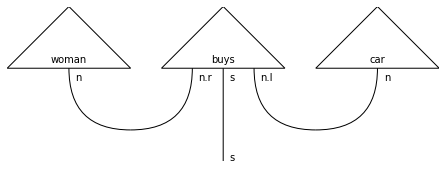

In [6]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ buys @ car >> grammar
pregroup.draw(sentence)

- noun + t. verb + adjective + noun (for english)

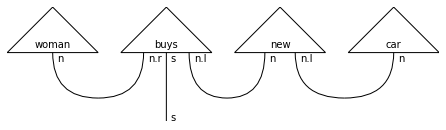

In [7]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n)
sentence = woman @ buys @ new @ car >> grammar
pregroup.draw(sentence)

- noun + t. verb + noun +adjective (for spanish)

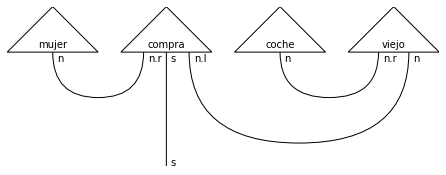

In [8]:
grammar =  Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)
sentence = mujer @ compra @ coche @ viejo >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [9]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'NVN' :  Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'NVAN' : Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n),
    'NVNA' : Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)}                                                                   

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# English noun+verb+noun sentences
parsing_NVNe = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in subjects for verb in verbs for obj in objects}
sentences_NVNe = list(parsing_NVNe.keys())
for sentence in sentences_NVNe:
    diagram = parsing_NVNe[sentence]
    data_psr[sentence] = parsing_NVNe[sentence]
    
# Spanish noun+verb+noun sentences
parsing_NVNs = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in sujetos for verb in verbos for obj in objetos}
sentences_NVNs = list(parsing_NVNs.keys())
for sentence in sentences_NVNs:
    diagram = parsing_NVNs[sentence]
    data_psr[sentence] = parsing_NVNs[sentence]
    
# English noun+verb+adjective+noun sentences
parsing_NVANe = {"{} {} {} {}.".format(subj, verb, adj, obj): subj @ verb @ adj @ obj  >> grammar_dict['NVAN']
            for subj in subjects  for verb in verbs for adj in adjectives for obj in objects}
sentences_NVANe = list(parsing_NVANe.keys())
for sentence in sentences_NVANe:
    diagram = parsing_NVANe[sentence]
    data_psr[sentence] = parsing_NVANe[sentence]
    
# Spanish noun+verb+noun+adjectives sentences
parsing_NVNAs = {"{} {} {} {}.".format(subj, verb, obj, adj): subj @ verb @ obj @ adj  >> grammar_dict['NVNA']
            for subj in sujetos for verb in verbos for obj in objetos  for adj in adjetivos}
sentences_NVNAs = list(parsing_NVNAs.keys())
for sentence in sentences_NVNAs:
    diagram = parsing_NVNAs[sentence]
    data_psr[sentence] = parsing_NVNAs[sentence]

### 1.3. Process the data 

In our experiments, we tested the algorithm with three different datasets. The $\textit{Small}$, $\textit{Medium}$ and $\textit{Big}$ datasets contain 20,65,90 sentences in English and 20,65,90 sentences in Spanish respectively. $\textit{DataSet_SI_...}$.txt files contain the sentences of each language, $\textit{TrainingSet_SI_...}$.txt and $\textit{TestSet_SI_...}$.txt include some combinations of English-Spanish sentences and their correct label (1 if they share meaning, 0 otherwise) which are used to train and test the algorithm respectively.   

In [10]:
#*****************************************************************************************************
#Load datasets containing sentences and labels
#*****************************************************************************************************
#Small (20 sentences in english and 20 in spanish; 400 possible combinations)
with open('DataSet_SI_eng_small.txt') as f:
    dataeng_small = f.readlines()
with open('DataSet_SI_spa_small.txt') as f:
    dataspa_small = f.readlines()
with open('TrainingSet_SI_labels_small.txt') as f: 
    train_labels_small = f.readlines() 
with open('TestSet_SI_labels_small.txt') as f: 
    test_labels_small = f.readlines() 
#Medium (65 sentences in english and 65 in spanish; 4225 possible combinations)
with open('DataSet_SI_eng_medium.txt') as f:
    dataeng_medium = f.readlines()
with open('DataSet_SI_spa_medium.txt') as f:
    dataspa_medium = f.readlines()
with open('TrainingSet_SI_labels_medium.txt') as f: 
    train_labels_medium = f.readlines() 
with open('TestSet_SI_labels_medium.txt') as f: 
    test_labels_medium = f.readlines() 
#Big (90 sentences in english and 90 in spanish; 8100 possible combinations)
with open('DataSet_SI_eng_big.txt') as f:
    dataeng_big = f.readlines()
with open('DataSet_SI_spa_big.txt') as f:
    dataspa_big = f.readlines()
with open('TrainingSet_SI_labels_big.txt') as f: 
    train_labels_big = f.readlines() 
with open('TestSet_SI_labels_big.txt') as f: 
    test_labels_big = f.readlines() 

In [11]:
#*****************************************************************************************************
#  Transform senteces into diagrams
#*****************************************************************************************************
#Small
dataeng_psr_dict_small, dataspa_psr_dict_small= {},{}
dict_small=[dataeng_psr_dict_small, dataspa_psr_dict_small]
sent_type_small={}
data_small=[dataeng_small,dataspa_small]
#Medium
dataeng_psr_dict_medium, dataspa_psr_dict_medium = {},{}
dict_medium=[dataeng_psr_dict_medium, dataspa_psr_dict_medium]
sent_type_medium={}
data_medium=[dataeng_medium,dataspa_medium]
#Big
dataeng_psr_dict_big, dataspa_psr_dict_big = {},{}
dict_big=[dataeng_psr_dict_big, dataspa_psr_dict_big]
sent_type_big={}
data_big=[dataeng_big,dataspa_big]
################
parsing=[parsing_NVNe,parsing_NVNs,parsing_NVANe,parsing_NVNAs]
types=['NVN','NVN','NVAN','NVNA']
for (datasize,dictsize,sent_type) in zip([data_small,data_medium,data_big],[dict_small,dict_medium,dict_big],
                                            [sent_type_small,sent_type_medium,sent_type_big]): 
    for (data,data_psr_dict)  in zip(datasize,dictsize):
        for sentence in data:
            sentstr = sentence[:-1]
            for (par,typ) in zip(parsing,types):
                if sentstr in list(par.keys()): 
                    diagram = par[sentstr]
                    data_psr_dict[sentstr] = diagram
                    sent_type[sentstr] = typ 

In [12]:
#*****************************************************************************************************
#  Save labels in lists to be used later on
#*****************************************************************************************************
#Training set (To train the paramenters)
train_labelslist_small,train_labelslist_medium,train_labelslist_big=[],[],[]
train_labelslist=[train_labelslist_small,train_labelslist_medium,train_labelslist_big]
trainset_labels=[train_labels_small,train_labels_medium,train_labels_big]
for (labelslist,labelsset) in zip(train_labelslist,trainset_labels):  
    for pair in labelsset:
        label=pair[-2]
        labelslist.append(label)
#Testing set (To test the trained paramenters)
test_labelslist_small,test_labelslist_medium,test_labelslist_big=[],[],[]
test_labelslist=[test_labelslist_small,test_labelslist_medium,test_labelslist_big]
testset_labels=[test_labels_small,test_labels_medium,test_labels_big]
for (labelslist,labelsset) in zip(test_labelslist,testset_labels):  
    for pair in labelsset:
        label=pair[-2]
        labelslist.append(label)

In [13]:
#*****************************************************************************************************
#  Remove resource-consumming cups and transform them into effects (see [2])
#*****************************************************************************************************
from discopy import Cap, Box
#Old data with cups
dataeng_psr_dict_sizes=[dataeng_psr_dict_small,dataeng_psr_dict_medium,dataeng_psr_dict_big]
dataspa_psr_dict_sizes=[dataspa_psr_dict_small,dataspa_psr_dict_medium,dataspa_psr_dict_big]
#New data with effects
dataeng_new_psr_dict_small,dataeng_new_psr_dict_medium,dataeng_new_psr_dict_big = {},{},{}
dataspa_new_psr_dict_small,dataspa_new_psr_dict_medium,dataspa_new_psr_dict_big = {},{},{}
dataeng_new_psr_dict_sizes=[dataeng_new_psr_dict_small,dataeng_new_psr_dict_medium,dataeng_new_psr_dict_big]
dataspa_new_psr_dict_sizes=[dataspa_new_psr_dict_small,dataspa_new_psr_dict_medium,dataspa_new_psr_dict_big]
###########
sent_type_size=[sent_type_small,sent_type_medium,sent_type_big]
for (dataeng_new_psr_dict,dataspa_new_psr_dict,
     dataeng_psr_dict,dataspa_psr_dict,sent_type) in zip(dataeng_new_psr_dict_sizes,dataspa_new_psr_dict_sizes,
                                                         dataeng_psr_dict_sizes,dataspa_psr_dict_sizes,sent_type_size):
    for (data_psr_dict,data_new_psr_dict)  in zip([dataeng_psr_dict,dataspa_psr_dict],
                                                  [dataeng_new_psr_dict,dataspa_new_psr_dict]):
        for sentstr in data_psr_dict.keys():
            num_words = len(sentstr.split(' '))
            words = data_psr_dict[sentstr].boxes[:num_words]
            if sent_type[sentstr] == 'NVN': #noun-verb-noun sentences (English and Spanish)
                noun1 = Box(words[0].name, n.r, Ty()) 
                noun2 = Box(words[2].name, n.l, Ty())
                words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2) # Rearranged words
                sentence = words_new >> grammar_dict['NVN']         # Apply grammar on rearranged words
                data_new_psr_dict[sentstr] = sentence.normal_form() # Store sentece with optimum diagram
            elif sent_type[sentstr] == 'NVAN': #noun-verb-adjective-noun sentences (English)
                noun1 = Box(words[0].name, n.r, Ty())
                noun2 = Box(words[3].name, n.l, Ty())
                words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
                sentence = words_new >> grammar_dict['NVAN']
                data_new_psr_dict[sentstr] = sentence.normal_form() 
            elif sent_type[sentstr] == 'NVNA': #noun-verb-noun-adjective sentences (Spanish)
                noun1 = Box(words[0].name, n.r, Ty())
                noun2 = Box(words[2].name, n.r, Ty())
                words_new = (Cap(n.r, n) @ Cap(n.r, n)) >> (noun1 @ Id(n) @ words[1] @ noun2 @ Id(n) @ words[3]) 
                sentence = words_new >> grammar_dict['NVNA']
                data_new_psr_dict[sentstr] = sentence.normal_form()

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [14]:
#*****************************************************************************************************
#  Redefine the vocabulary according to the new domain and code nouns as effects.
#*****************************************************************************************************
from discopy import Cap, Box
#English
vocab_psr_E = []
for word in vocab_E:
    if word.cod == Ty('n'):
        vocab_psr_E.append(Box(word.name, n.r, Ty()))   
    else:
        vocab_psr_E.append(word)
#Spanish
vocab_psr_S = []
for word in vocab_S:
    if word.cod == Ty('n'):
        vocab_psr_S.append(Box(word.name, n.r, Ty()))  
    else:
        vocab_psr_S.append(word)
vocab_psr=vocab_psr_E+vocab_psr_S

## 2. Create quantum circuit

Once we have created the dataset and its corresponding diagrams, the next step is to build the variational quantum circuits associated with them. To do that, we will use different ansätze depending on the type of word that we want to represent. In this case, we have three types of words: nouns, adjectives, and verbs. Therefore, we must define an ansatz that depends on several parameters for each word. Combining these ansätze as given by how the words interact in the diagram that represents the sentence, we build a parameterized quantum circuit. 

To design a convenient ansatz we need to look at the NPL problem that we are solving. In addition, we want to minimize the size of the quantum circuits and the number of parameters, but maximizing the performance of the algorithm. Although other alternatives are possible, in our implementation we establish that nouns will have 1 qubit associated with them (because we want to keep the circuits as small as possible), and sentences two qubits (because we need a Hilbert space that is large enough to encode multiple different meanings). Therefore verbs are built with 4 qubits, and adjectives with 2 qubits. With the former in mind, we map nouns as a single qubit Rx rotation (so just one variational parameter is needed), and we use the IQP ansätze as defined in [2] to verbs and adjectives. 

In [5]:
#*****************************************************
# Functions to deal with the ansätze (functions from [2])
#*****************************************************

from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum.gates import Rx, Rz
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.circuit import Circuit
from functools import reduce, partial

q_s = 2 # number of qubits for type s (sentence)
q_n = 1 # number of qubits for type n (noun)
depth = 1 # depth of the IQPansatz
p_n = 1       # number of parameters for a single-qubit word (noun); valued in {1,2,3}.

# Define the dimensions of the objects of the circuit functor
ob = {s: q_s, n: q_n}                          
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   

# Define the ansätze for states and effects

def single_qubit_iqp_ansatz(params):
    if len(params) == 1:
        return Rx(params[0])  
    if len(params) == 2:
        return Rx(params[0]) >> Rz(params[1])
    if len(params) == 3:
        return IQPansatz(1, params) 

def ansatz_state(state, params):  
    arity = sum(ob[Ty(factor.name)] for factor in state.cod)
    if arity == 1:
        return Ket(0) >> single_qubit_iqp_ansatz(params)
    else:
        return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params):  
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    if arity == 1:
        return single_qubit_iqp_ansatz(params) >> Bra(0)
    else:
        return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

# Construct the circuit functor
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})
    return Functor(ob_cqmap, ar)

In [16]:
#*****************************************************
# Functions to deal with the parametrisation (functions from [2])
#*****************************************************

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0: 
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            if arity == 1:
                parshapes.append((p_n,))       
            if arity != 1:
                parshapes.append((depth, arity-1))
    return parshapes

def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i]))))
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

We can check how many parameters have to be optimized in our current model (or what is the same, how many parameters define all the sentences in our dataset).

In [17]:
#****************************************
# Parameters of the current model
#****************************************

par_shapes = paramshapes(vocab_psr)
rand_unshaped_pars = randparams(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     36


man buys notebook.


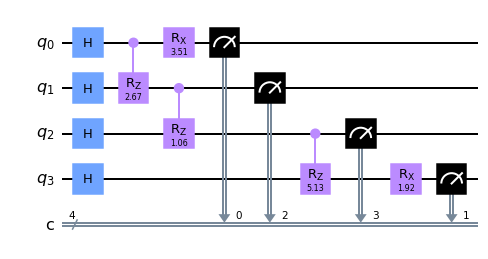

In [153]:
#****************************************
# Transform sentences diagrams into Qiskit Quantum Circuits
#****************************************
from pytket.extensions.qiskit import tk_to_qiskit
from discopy.quantum import Measure

def to_qiskitcircuit(unshaped_params,diagrams_dict): 
    """Function to transform a DisCoCat diagram into a Qiskit Quantum Circuit.
    Args:
        unshaped_params = parameters to the variationals circuits.
        diagrams_dict = dictionary with the sentences as keys and their diagrams as values.
    Returns:
        Qiskit Quantum Circuit.
    """
    func = F(reshape_params(unshaped_params, par_shapes))
    circs=[]
    for sentstr in diagrams_dict.keys():
        diagram=diagrams_dict[sentstr]
        circuit=(func(diagram) >> Measure() @ Measure()) #Add the measurements to the circuit
        pytket_circuit = circuit.to_tk()
        qiskit_circuit = tk_to_qiskit(pytket_circuit)   #Create Qiskit Quantum Circuit
        circs.append(qiskit_circuit)
    return circs
########## 
#For example (with random parameters "rand_shaped_pars")

circuits_eng_small,circuits_eng_medium,circuits_eng_big=[],[],[]
circuits_spa_small,circuits_spa_medium,circuits_spa_big=[],[],[]
circuits_eng = [circuits_eng_small,circuits_eng_medium,circuits_eng_big] # list of Qiskit Quantum Crcuits of english sentences 
circuits_spa = [circuits_spa_small,circuits_spa_medium,circuits_spa_big] # list of Qiskit Quantum Circuits of spanish sentences 
for (circ_eng,circ_spa,dataeng_new_psr_dict,dataspa_new_psr_dict) in zip(circuits_eng,circuits_spa,
                                                                         dataeng_new_psr_dict_sizes,dataspa_new_psr_dict_sizes):
    for (circ,data_new_psr_dict)  in zip([circ_eng,circ_spa],
                                                  [dataeng_new_psr_dict,dataspa_new_psr_dict]):
        circ.append(to_qiskitcircuit(rand_unshaped_pars,data_new_psr_dict))

j=2
print(list(dataeng_new_psr_dict_medium.keys())[j])
circuits_eng_medium[0][j].draw(output='mpl',filename='circuit_example_NVN.pdf')

woman steals red car.


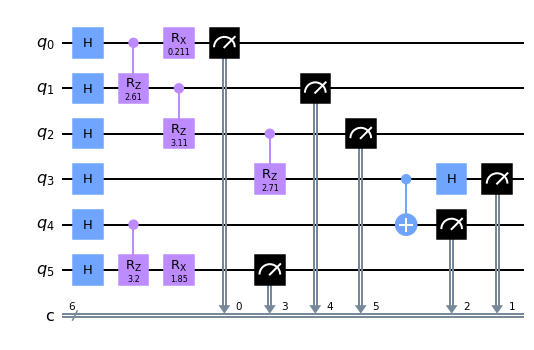

In [151]:
j=45
print(list(dataeng_new_psr_dict_medium.keys())[j])
circuits_eng_medium[0][j].draw(output='mpl',filename='circuit_example_ADJenglish.pdf')

mujer roba coche rojo.


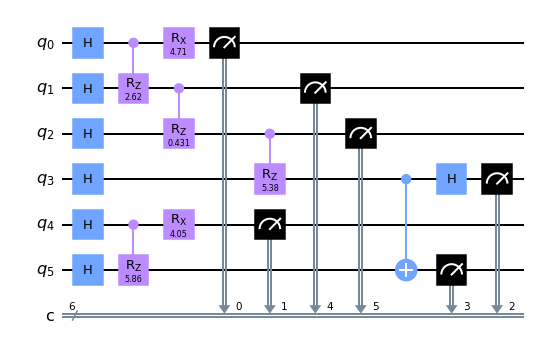

In [152]:
j=30
print(list(dataspa_new_psr_dict_medium.keys())[j])
circuits_spa_medium[0][j].draw(output='mpl',filename='circuit_example_ADJspanish.pdf')

We can see from the above examples that the $\textit{sentence qubits}$ will always be qubit 1 and 2 (in our data set), and they are measured in the last two classical registers (important for postselection). 

## 4. Hybrid quantum-classical variational algorithm

The parameters of the variational quantum circuits that we have derived need to be optimized to accomplish our NPL task (multi-language semantic interpretation). For doing so, we will apply a hybrid quantum-classical supervised machine learning similar to a variational quantum eigensolver (VQE). This algorithm combines a classical optimizer such as SPSA or COBYLA with quantum computing. The classical optimization method tries to find the optimal variational parameters which fit the task by minimizing a cost function whose evaluation or estimation depends on the measurements of the quantum circuits. The difference with VQE is that, instead of optimizing just one circuit, we optimize as many circuits as sentences we have in the dataset.

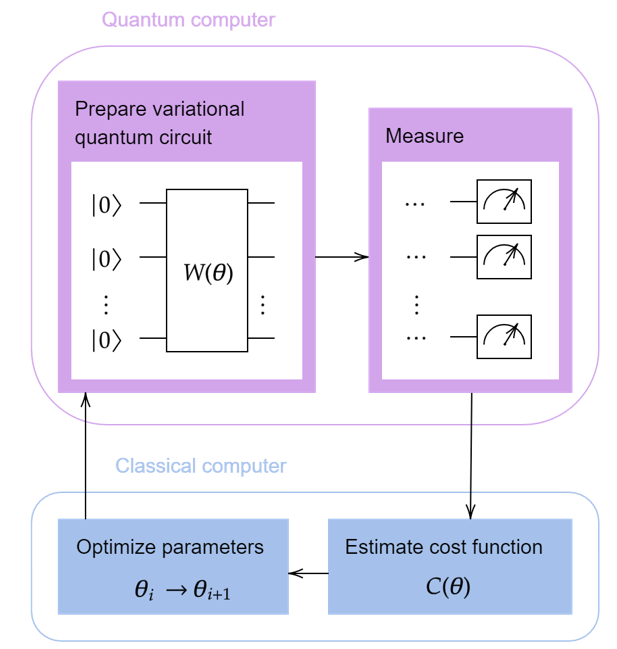

In [165]:
#****************************************
# Load qiskit classes to execute circuits and IBM-Q account
#****************************************
from qiskit import BasicAer, execute, Aer, IBMQ
from qiskit.quantum_info import Statevector
from qiskit.providers.aer.noise import NoiseModel
provider=IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-06-03 00:29:22,061: Credentials are already in use. The existing account in the session will be replaced.


In [166]:
#****************************************
# Functions to perform the hybrid quantum-classical machine learning (optimization of variational parameters) 
#****************************************
####Predict labels (which sentences have the same meaning)
def get_probs(unshaped_params,withshots=True,simulation=True,withnoise=False):
    """Function to get the predicted labels of our dataset from a specific set of parameters.
    Args:
        unshaped_params = parameters to the variationals circuits.
        withshots = True: a limited number of shots will be performed or simulated; False: a classical simulation 
        equivalent to an unlimited number of shots is performed (statevector simulation). (Default True)
        simulation = True: QASM or statevector simulation ; False: real quantum device (ibmq_16_melbourne). (Default True)
        withnoise = True: simulate ibmq_16_melbourne noise and architecture; False: not noise model. (Default False)
    Returns:
        array: predicted labels.
    """
    circuits_eng = to_qiskitcircuit(unshaped_params,diagrams_eng)
    circuits_spa = to_qiskitcircuit(unshaped_params,diagrams_spa)
    if withshots:
        if simulation:
            if withnoise:
                # Build noise model from backend properties
                backend = provider.get_backend('ibmq_16_melbourne')
                noise_model = NoiseModel.from_backend(backend)
                # Get coupling map from backend
                coupling_map = backend.configuration().coupling_map
                # Get basis gates from noise model
                basis_gates = noise_model.basis_gates
            else:
                noise_model,coupling_map,basis_gates = None,None,None
            backend=Aer.get_backend('qasm_simulator') 
            results=execute(circuits_eng+circuits_spa, backend=backend,shots=n_shots, noise_model=noise_model,
                            coupling_map=coupling_map,basis_gates=basis_gates).result().get_counts()
        else:
            ibmq_device='ibmq_16_melbourne'
            backend=IBMQ.get_provider(group='internal').get_backend(ibmq_device)
            results=execute(circuits_eng+circuits_spa, backend=backend,shots=n_shots).result().get_counts()
        results_eng=results[:len(circuits_eng)]
        results_spa=results[len(circuits_spa):]
        pred_labels_distrs=[]    
        for countssent_eng in results_eng: #Loop over English sentences
            for countssent_spa in results_spa: #Loop over Spanish sentences
                predlabel=0
                for bits in countssent_eng.keys():
                    if bits[q_s:]==len(bits[q_s:])*'0': #Postselection
                        if bits in countssent_spa.keys():
                            predlabel+=countssent_eng[bits]*countssent_spa[bits]
                        else:
                            predlabel+=0
                counteng_select,countspa_select=0,0
                for bits in countssent_eng.keys():
                    if bits[q_s:]==len(bits[q_s:])*'0':
                        counteng_select+=countssent_eng[bits]
                for bits in countssent_spa.keys():
                    if bits[q_s:]==len(bits[q_s:])*'0':
                        countspa_select+=countssent_spa[bits]
                if counteng_select==0 or countspa_select==0:
                    #print('Total postselction 0')
                    label=1e-9
                else:
                    label=abs(predlabel/(counteng_select*countspa_select) - 1e-9) #Final label
                pred_labels_distrs.append(label)
        maxlabel=max(pred_labels_distrs)
        pred_labels_distrs_norm=[x/maxlabel for x in pred_labels_distrs]       
    elif simulation:
        backend=Aer.get_backend('statevector_simulator')
        state_vector_dicts=[]
        for circ in circuits_eng+circuits_spa:
            circ.remove_final_measurements()
            state_vector_dicts.append(Statevector(circ).to_dict())
        qsen=[1,2]
        pred_labels_distrs=[]    
        for countssent_eng in state_vector_dicts[:len(circuits_eng)]:
            for countssent_spa in state_vector_dicts[len(circuits_spa):]:
                predlabel=0
                for bits in countssent_eng.keys():
                    selections = ['0' * qsen[0] + val + '0' * (len(bits) - qsen[1] - 1) for val in ['00', '01', '10', '11']]
                    if bits in selections:   #Postselection
                        if bits in countssent_spa.keys():
                            predlabel+=abs(countssent_eng[bits]**2*countssent_spa[bits]**2)
                        else:
                            predlabel+=0
                counteng_select,countspa_select=0,0
                for bits in countssent_eng.keys():
                    if bits in selections:
                        counteng_select+=abs(countssent_eng[bits]**2)
                for bits in countssent_spa.keys():
                    if bits in selections:
                        countspa_select+=abs(countssent_spa[bits]**2)
                if counteng_select==0 or countspa_select==0: 
                    label=1e-9
                else:
                    label=abs(predlabel/(counteng_select*countspa_select) - 1e-9)  #Final label
                pred_labels_distrs.append(label)
        maxlabel=max(pred_labels_distrs)
        pred_labels_distrs_norm=[x/maxlabel for x in pred_labels_distrs]   
    return pred_labels_distrs_norm

####Two possible cost functions for the model (the function that the machine tries to minimize)
def get_cost_crossentropy(pred_labels_distrs):
    """Function to compute the binary cross-entropy from predicted labels.
    Args:
        pred_labels_distrs = array of predicted labels.
    Returns:
        float: binary cross-entropy.
    """
    cross_entropies = np.array([int(train_labels[s]) * math.log2(pred_labels_distrs[s]) 
                                for s in range(len(train_labels)) if train_labels[s]!='x'])
    return -1 / len([train_labels[s] for s in range(len(train_labels)) if train_labels[s]!='x']) * np.sum(cross_entropies)

def get_cost_absoluteerror(pred_labels_distrs): 
    """Function to compute the absolute error of the predicted labels with respect to the correct ones.
    Args:
        pred_labels_distrs = array of predicted labels.
    Returns:
        float: absolute error.
    """
    error = 0
    train_size=0
    for (i, res) in enumerate(pred_labels_distrs):
        if train_labels[i]!='x': 
            train_size+=1
            error+=abs(int(train_labels[i])-res)
    return error * 100 / train_size

####Error functions for the model (a measure of how many sentences the quantum device translates correctly)
def get_train_error(pred_labels_distrs): 
    """Function to compute the percentage of sentences in the training set that the predicted labels translate correctly.
    Args:
        pred_labels_distrs = array of predicted labels.
    Returns:
        float: percentage of correct translations.
    """
    correct = 0
    train_size=0
    for (i, res) in enumerate(pred_labels_distrs):
        if train_labels[i]!='x': 
            train_size+=1
            try:
                pred_result = round(res) #We are taking as 1 (same meaning) when the output is >0.5 and viceversa
            except:
                pred_result = None
            else:
                pass
            train_result = round(int(train_labels[i])) 
            if train_result == pred_result:
                correct += 1
    return 100 - correct * 100 / train_size

def get_test_error(pred_labels_distrs):    
    """Function to compute the percentage of sentences in the test set that the predicted labels translate correctly.
    Args:
        pred_labels_distrs = array of predicted labels.
    Returns:
        float: percentage of correct translations.
    """
    correct = 0
    test_size=0
    for (i, res) in enumerate(pred_labels_distrs):
        if test_labels[i]!='x': 
            test_size+=1
            pred_result = round(res) #We are taking as 1 (same meaning) when the output is >0.5 and viceversa
            test_result = round(int(test_labels[i])) 
            if test_result == pred_result:
                correct += 1
    return 100 - correct * 100 / test_size

####Other useful functions for performing optimization and tracking intermediate results
def objective_function(unshaped_params,costfunction=get_cost_absoluteerror): #cost_function=get_cost_crossentropy or 
    """Objective function to perform an evaluation of the classical optimization from a specific set of parameters.
    Args:
        unshaped_params = parameters to the variationals circuits.
        costfunction = cost function that will be minimized by the classical optimization method. 
        The options are "get_cost_crossentropy" or "get_cost_absoluteerror". (Default get_cost_absoluteerror)
    Returns:
        float: value of cost function.
    """                                                                    
    #To perform optimization
    pred_labels_distrs=get_probs(unshaped_params,withshots=withshots,simulation=simulation,withnoise=withnoise)
    cost=costfunction(pred_labels_distrs)
    #To track the results
    trainerror=get_train_error(pred_labels_distrs)
    testerror=get_test_error(pred_labels_distrs)
    cost_crossentr=get_cost_crossentropy(pred_labels_distrs)
    cost_abserr=get_cost_absoluteerror(pred_labels_distrs)
    tracking=callback(trainerror,testerror,cost_crossentr,cost_abserr)
    return cost  

def callback(trainerror,testerror,cost_crossentr,cost_abserr):
     """Function to track the results in each objective function evaluation.
    Args:
        trainerror = array of get_train_error values for each objective function evaluation.
        testerror = array of get_test_error values for each objective function evaluation.
        cost_crossentr = array of get_cost_crossentropy values for each objective function evaluation.
        cost_abserr = array of get_cost_absoluteerror values for each objective function evaluation.
    Returns:
         -
    """
    global error_train_history,error_test_history,cost_crossentropy_history,cost_abserror_history,nevaluations
    error_train_history[run].append(trainerror)
    error_test_history[run].append(testerror)
    cost_crossentropy_history[run].append(cost_crossentr)
    cost_abserror_history[run].append(cost_abserr)
    print("Cost_AbsErr: {} ,Cost_CrossEntr: {} , ErrorTrain: {}, ErrorTest: {}".format(cost_abserr,cost_crossentr,
                                                                                      trainerror,testerror))
    nevaluations+=1
    print('NºEvals: ',nevaluations)

Finally, we can run the optimizer and obtain the results.

In [ ]:
#************************************
# Quantum-Classical run: training and error calculation
#************************************
from time import time
from qiskit.algorithms.optimizers import COBYLA,SPSA,L_BFGS_B

####Experiment Parameters
n_runs = 1
niter = 2000
cost_function=get_cost_absoluteerror #costfunction=get_cost_crossentropy or get_cost_absoluteerror
method='SPSA' #Classical optimization method= 'COBYLA','SPSA' or'L_BFGS_B'
n_shots = 8192  # number of shots (maximum in real hardware: 8192)
withshots=True
simulation=True
withnoise=True
dataset='small' #dataset='small','medium','big'

####Data for the experiment
if dataset=='small':
    #Diagrams
    diagrams_eng = dataeng_new_psr_dict_small
    diagrams_spa = dataspa_new_psr_dict_small 
    #Training and test labels
    train_labels = train_labelslist_small
    test_labels = test_labelslist_small
if dataset=='medium':
    #Diagrams
    diagrams_eng = dataeng_new_psr_dict_medium
    diagrams_spa = dataspa_new_psr_dict_medium 
    #Training and test labels
    train_labels = train_labelslist_medium
    test_labels = test_labelslist_medium
if dataset=='big':
    #Diagrams
    diagrams_eng = dataeng_new_psr_dict_big
    diagrams_spa = dataspa_new_psr_dict_big 
    #Training and test labels
    train_labels = train_labelslist_big
    test_labels = test_labelslist_big
    
####Classical Optimizers (from qiskit.algorithms.optimizers)
if method=='COBYLA':
    optimizer=COBYLA(maxiter=niter)
elif method=='SPSA': #Some additional function evaluations are performed to calibrate the hyperparameters
    optimizer=SPSA(maxiter=niter)
elif method=='L_BFGS_B':
    optimizer=L_BFGS_B(maxiter=niter)

####Tracking variables
param_histories = [[] for r in range(n_runs)]
error_train_history,error_test_history = [[] for r in range(n_runs)],[[] for r in range(n_runs)]
cost_crossentropy_history,cost_abserror_history = [[] for r in range(n_runs)],[[] for r in range(n_runs)]
final_result=[]

####Running
for run in range(n_runs):
    print('---------------------------------')
    print('Start run ', run+1)
    rand_unshaped_pars = randparams(par_shapes)
    start = time()
    nevaluations=0
    res = optimizer.optimize(len(rand_unshaped_pars),objective_function,initial_point=rand_unshaped_pars) #Optimization
    print("Parameters: {} ,CostFunction: {} , NºEvaluations: {}".format(res[0],res[1],res[2]))
    final_result.append(res)
    print('run', run+1, 'done')
    print('Time taken: ', time() - start)

####Save the results
data = {'param_histories': param_histories,
        'cost_crossentropy_history': cost_crossentropy_history,
        'cost_abserror_history': cost_abserror_history,
        'error_train_history': error_train_history,
        'error_test_history': error_test_history,
       'final_result': final_result}
with open('SIresults_it'+str(niter)+'_met'+method+'_size-'+dataset+'_sim'+str(simulation)+'_shots'+str(withshots)+
          str(n_shots)+'_withnoise'+str(withnoise)+'_costabserr'+'_0.pickle', 'wb') as file_handle:
    pickle.dump(data, file_handle)

## 5. Results and plots

In [6]:
#************************************
# Results
#************************************
import matplotlib.pyplot as plt

#######StateVector Simulations
#SPSA 200 iterations
with open('SIresults_it200_metSPSA_size-small_simTrue_shotsFalse8192_costabserr_0.pickle', 'rb') as f: 
    small_sv_spsa200=pickle.load(f)
with open('SIresults_it200_metSPSA_size-medium_simTrue_shotsFalse8192_costabserr_0.pickle', 'rb') as f: 
    medium_sv_spsa200=pickle.load(f)
with open('SIresults_it200_metSPSA_size-big_simTrue_shotsFalse8192_costabserr_0.pickle', 'rb') as f: 
    big_sv_spsa200=pickle.load(f)
#SPSA 1000 iterations
with open('SIresults_it1000_metSPSA_size-small_simTrue_shotsFalse8192_costabserr_0.pickle', 'rb') as f: 
    small_sv_spsa1000=pickle.load(f)
with open('SIresults_it1000_metSPSA_size-medium_simTrue_shotsFalse8192_withnoiseFalse_costabserr_0.pickle', 'rb') as f: 
    medium_sv_spsa1000=pickle.load(f)
with open('SIresults_it1000_metSPSA_size-big_simTrue_shotsFalse8192_withnoiseFalse_costabserr_0.pickle', 'rb') as f: 
    big_sv_spsa1000=pickle.load(f)
#COBYLA 1000 ev
with open('SIresults_it1000_metCOBYLA_size-small_simTrue_shotsFalse8192_costabserr_0.pickle', 'rb') as f: 
    small_sv_cobyla1000=pickle.load(f)
with open('SIresults_it1000_metCOBYLA_size-medium_simTrue_shotsFalse8192_withnoiseFalse_costabserr_0.pickle', 'rb') as f: 
    medium_sv_cobyla1000=pickle.load(f)
with open('SIresults_it1000_metCOBYLA_size-big_simTrue_shotsFalse8192_withnoiseFalse_costabserr_0.pickle', 'rb') as f: 
    big_sv_cobyla1000=pickle.load(f)
    
#######QASM Simulations
#200 iterations
with open('SIresults_it200_metSPSA_size-small_simTrue_shotsTrue8192_costabserr_0.pickle', 'rb') as f: 
    small_qs_spsa200=pickle.load(f)
with open('SIresults_it200_metSPSA_size-medium_simTrue_shotsTrue8192_costabserr_0.pickle', 'rb') as f: 
    medium_qs_spsa200=pickle.load(f)
with open('SIresults_it200_metSPSA_size-big_simTrue_shotsTrue8192_costabserr_0.pickle', 'rb') as f: 
    big_qs_spsa200=pickle.load(f)
#2000 iterations
with open('SIresults_it2000_metSPSA_size-small_simTrue_shotsTrue8192_costabserr_0.pickle', 'rb') as f: #
    small_qs_spsa2000=pickle.load(f)
with open('SIresults_it2000_metSPSA_size-medium_simTrue_shotsTrue8192_costabserr_0.pickle', 'rb') as f: 
    medium_qs_spsa2000=pickle.load(f)
with open('SIresults_it2000_metSPSA_size-big_simTrue_shotsTrue8192_costabserr_0.pickle', 'rb') as f: 
    big_qs_spsa2000=pickle.load(f)
    
####Noisy QASM Simulations
#300 iterations
with open('SIresults_it300_metSPSA_size-medium_simTrue_shotsTrue8192_withnoiseTrue_costabserr_0.pickle', 'rb') as f: 
    medium_mel_spsa300=pickle.load(f)
with open('SIresults_it300_metSPSA_size-big_simTrue_shotsTrue8192_withnoiseTrue_costabserr_0.pickle', 'rb') as f: 
    big_mel_spsa300=pickle.load(f)
#2000 iterations
with open('SIresults_it2000_metSPSA_size-small_simTrue_shotsTrue8192_withnoiseTrue_costabserr_0.pickle', 'rb') as f: 
    small_mel_spsa2000=pickle.load(f)

In [11]:
####Functions to process the results obtained from SPSA optimization
def process_result(result,nit):
    """Function to process SPSA results.
    Args:
        result = array of specific results (cost function or error).
        nit = number of iterations performed in SPSA optimization.
    Returns:
        array: processed results.
    """  
    res=result[-(nit*2):] #remove calibration steps
    return [(res[i]+res[i+1])/2 for i in range(len(res)) if i%2==0]
def secondprocess_result(processresult,nit):
    """Function to obtain the trend of the results.
    Args:
        processresult = array of result processed by process_result.
        nit = number of iterations performed in SPSA optimization.
    Returns:
        [array,array]: [np.arange of the points, trend].
    """  
    res = processresult
    number = 20
    y = [sum([res[i+x] for x in range(number)])/number for i in range(len(processresult)) if i%number==0]
    x = np.arange(0,nit,nit/len(y))
    return x,y

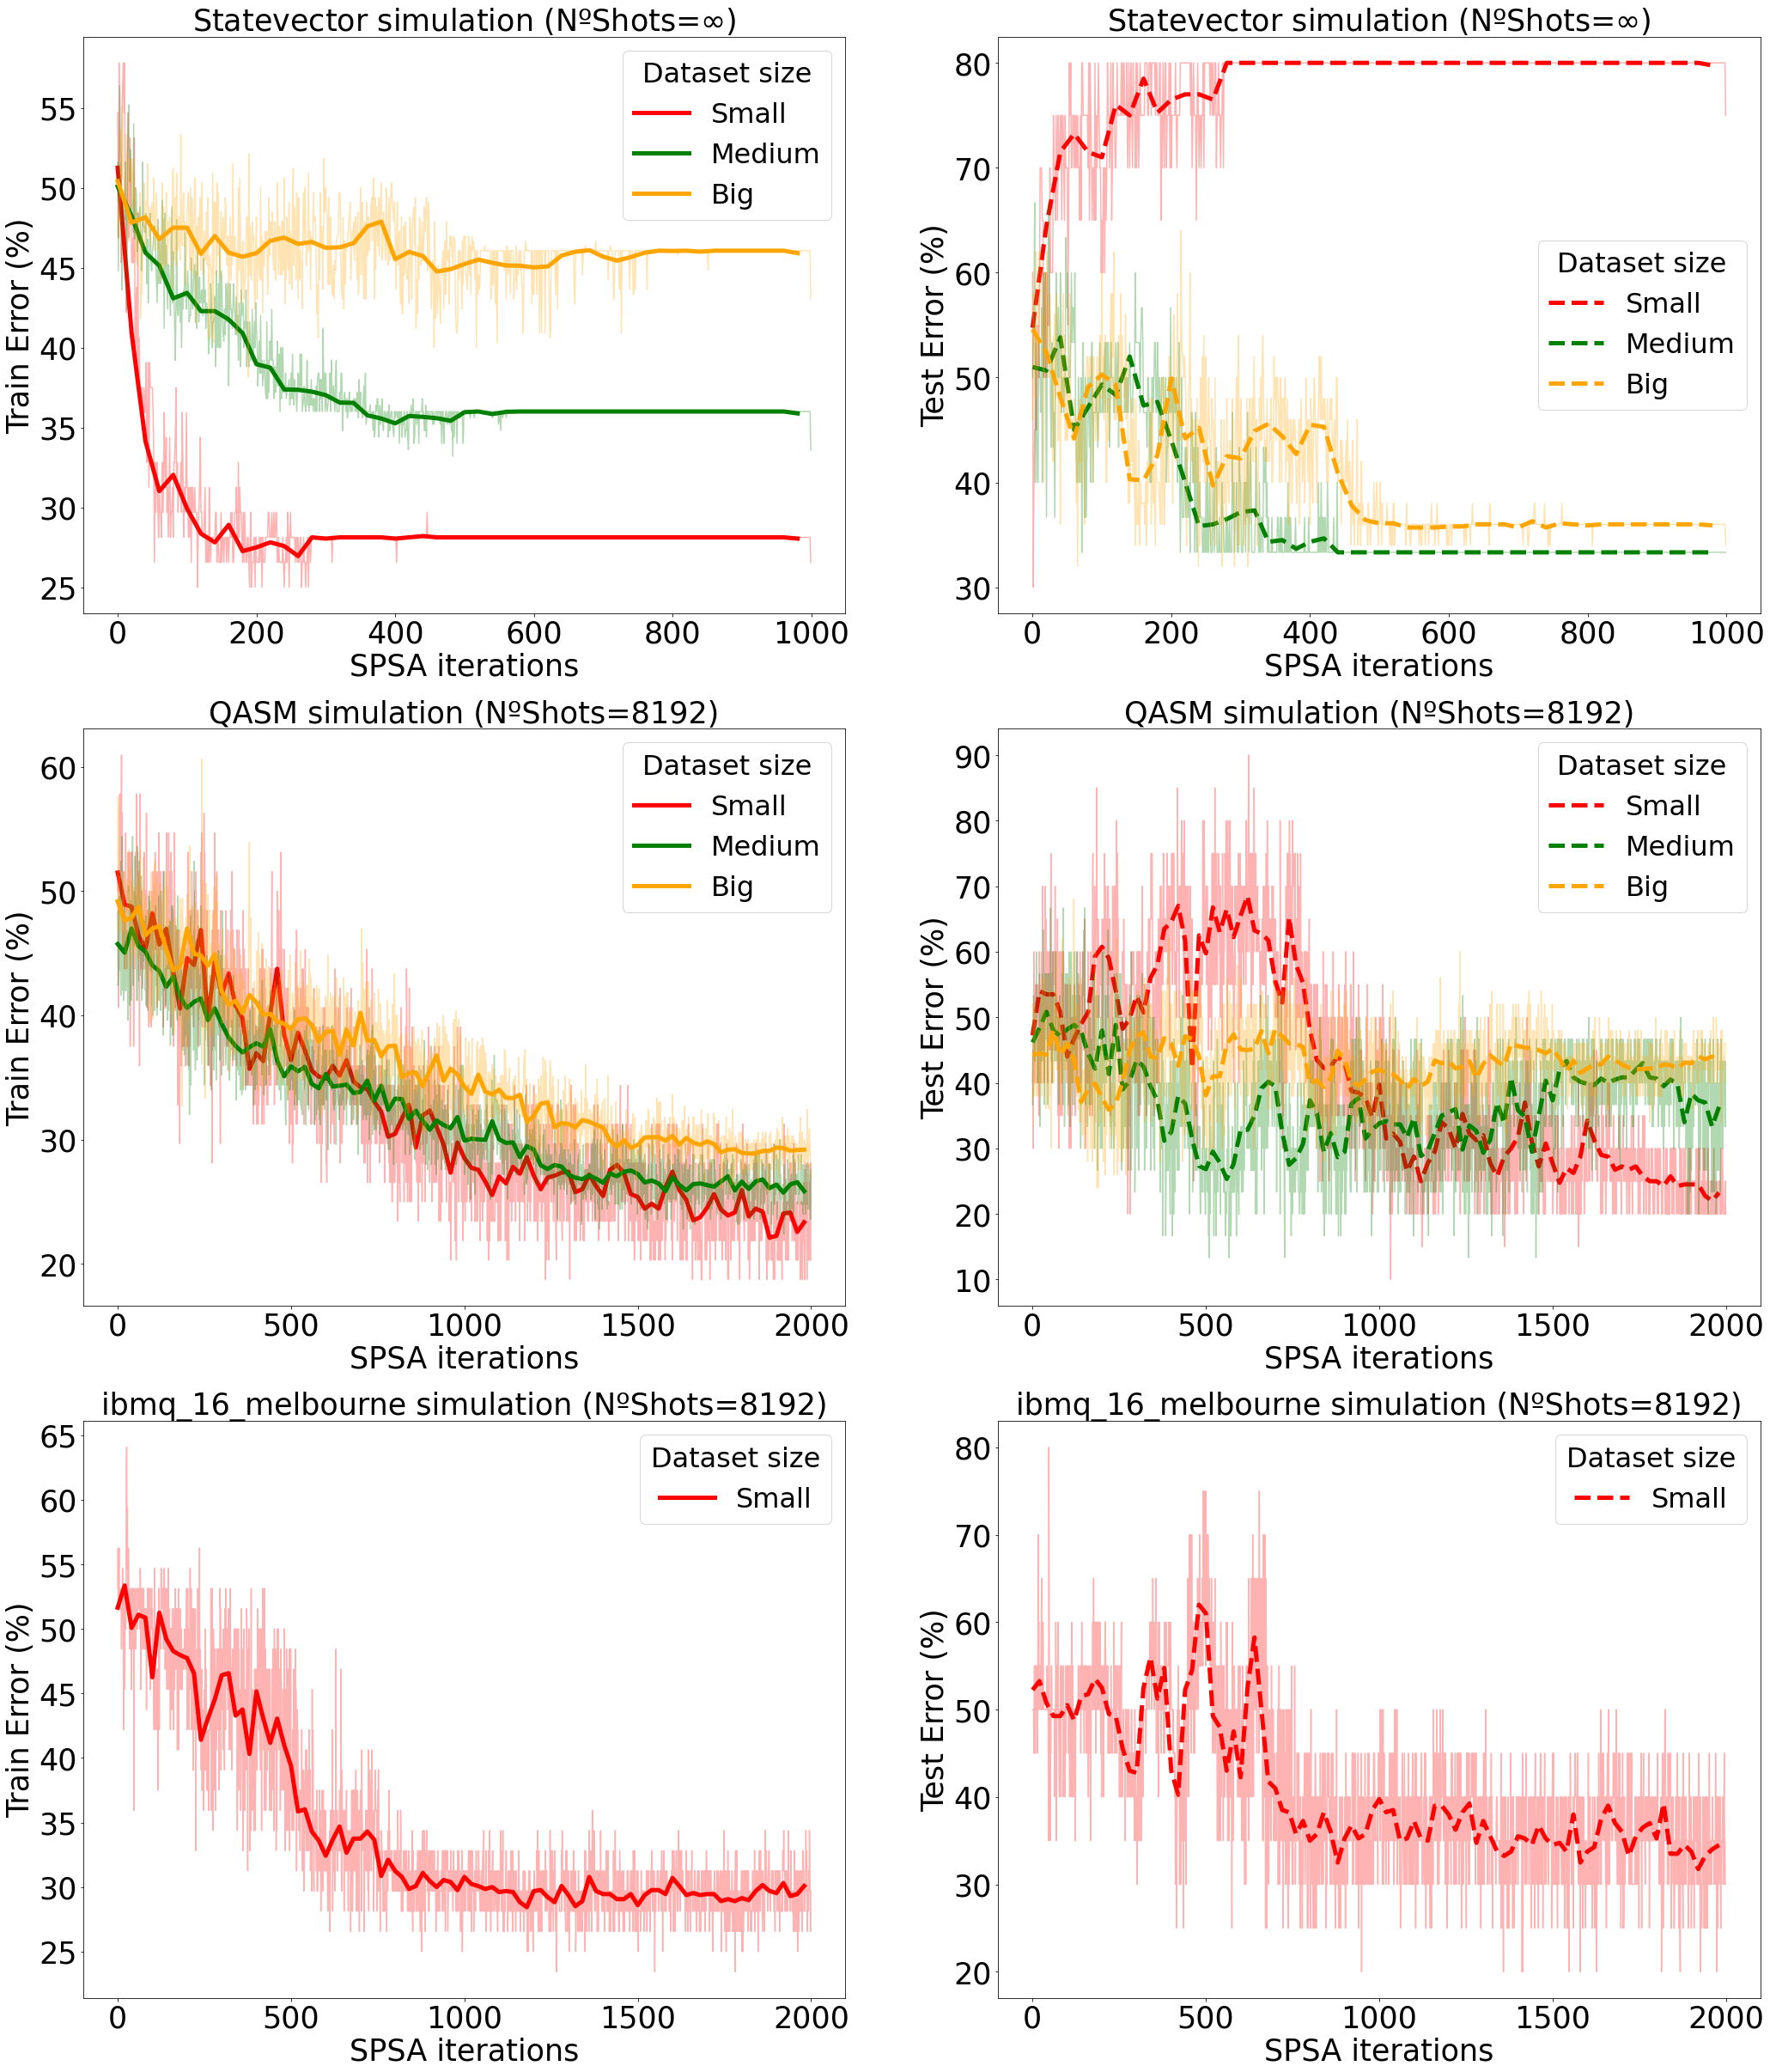

In [24]:
#************************************
# Plot the Results
#************************************
fig, axes = plt.subplots(3,2,figsize=(35,42)) 
nit=[1000,2000,2000]
font=35
lw=5
colors=['red','green','orange']
label=['Small','Medium','Big']
results=[[small_sv_spsa1000,medium_sv_spsa1000,big_sv_spsa1000],[small_qs_spsa2000,medium_qs_spsa2000,big_qs_spsa2000],
        [small_mel_spsa2000]]
titles=[r'Statevector simulation (NºShots=$\infty$)',r'QASM simulation (NºShots=8192)',
        'ibmq_16_melbourne simulation (NºShots=8192)']
for (result,ax,title,it) in zip(results,axes[:,0],titles,nit):
    for (res,col,lab) in zip(result,colors,label):
        y=process_result(res['error_train_history'][0],it)[:it]
        x=np.arange(0,len(y))
        pl=ax.plot(x,y,color=col,alpha=0.3)
        x2,y2 = secondprocess_result(y,it)
        pl=ax.plot(x2,y2,color=col,label=lab,linewidth=lw)
    ax.set_ylabel('Train Error (%)',fontsize=font)
    ax.set_xlabel('SPSA iterations',fontsize=font)
    ax.set_title(title,fontsize=font)
    ax.tick_params(axis='both', labelsize=font)
    leg=ax.legend(title='Dataset size',fontsize=font-3)
    plt.setp(leg.get_title(),fontsize=font-3)
for (result,ax,title,it) in zip(results,axes[:,1],titles,nit):
    for (res,col,lab) in zip(result,colors,label):
        y=process_result(res['error_test_history'][0],it)
        x=np.arange(0,len(y))
        pl=ax.plot(x,y,color=col,alpha=0.3)
        x2,y2 = secondprocess_result(y,it)
        pl=ax.plot(x2,y2,color=col,label=lab,linewidth=lw,linestyle='--')
    ax.set_ylabel('Test Error (%)',fontsize=font)
    ax.set_xlabel('SPSA iterations',fontsize=font)
    ax.set_title(title,fontsize=font)
    ax.tick_params(axis='both', labelsize=font)
    leg=ax.legend(title='Dataset size',fontsize=font-3)
    plt.setp(leg.get_title(),fontsize=font-3)   
plt.savefig('results_itSPSA.pdf')
plt.show(pl)   

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table